In [1]:
import pandas as pd

df = pd.read_csv("concatenated_df.csv")

In [2]:
df.head()

df['labels'] = df["labels"].astype(int)

In [3]:
import nltk
import string
import random
import re
import spacy

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

random.seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
!python -m spacy download nl_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/nl_core_news_sm-3.7.0/nl_core_news_sm-3.7.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')


In [5]:
# Load Dutch stopwords
dutch_stopwords = set(stopwords.words('dutch'))

# Load spaCy's Dutch language model
nlp = spacy.load('nl_core_news_sm')

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in dutch_stopwords]
    # Lemmatize the tokens using spaCy
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc]
    # Join tokens back into a single string
    text = ' '.join(tokens)
    return text

In [6]:
df['text'] = df['text'].apply(preprocess_text)

In [7]:
df.head()

,text,labels,fuel_type,year
0,Den Haag okt minister andriessen economisch za...,2,coal,1960s
1,koal mijn verbruiker brengen prijs terugbetale...,2,coal,1960s
2,kol willen centrale olie te slot product grote...,2,coal,1960s
3,ons haags redactie I Den Haag nov memorie antw...,2,coal,1960s
4,argument overwegend komen studiecommissie volg...,2,coal,1960s


In [9]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('combined-160.txt')

In [10]:
import numpy as np

# Function to process text and get average vector
def get_average_vector(text, model, num_features):
    words = text.split()
    vectors = [model[word] for word in words if word in model]
    if vectors:
        avg_vector = np.mean(vectors, axis=0)
    else:
        avg_vector = np.zeros(num_features)  # Return zero vector if no words found in model
    return avg_vector

num_features = model.vector_size

In [11]:
df['vector'] = df['text'].apply(lambda x: get_average_vector(x, model, num_features))

In [12]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [13]:
!python pip install imblearn

C:\Users\danie\AppData\Local\Programs\Python\Python311\python.exe: can't open file 'c:\\GitHub\\ADS-Thesis-Project\\pip': [Errno 2] No such file or directory


In [14]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy = 'not minority')

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

fuel_types = df['fuel_type'].unique()


overall_y_true = []
overall_y_pred = []

for fuel_type in fuel_types:
    df_fuel_train = train_df[train_df['fuel_type'] == fuel_type]
    df_fuel_test = test_df[test_df['fuel_type'] == fuel_type]

    x_train = df_fuel_train['vector'].tolist()
    y_train = df_fuel_train['labels']

    x_test = df_fuel_test['vector'].tolist()
    y_test = df_fuel_test['labels']  

    x_resampled, y_resampled = rus.fit_resample(x_train, y_train)

    model = LogisticRegression(max_iter=5000, penalty='l2')
    model.fit(x_resampled, y_resampled)
    
    # Make predictions
    y_pred = model.predict(x_test)

    overall_y_true.extend(y_test)
    overall_y_pred.extend(y_pred)

# Compute overall metrics
accuracy = accuracy_score(overall_y_true, overall_y_pred)
classification_rep = classification_report(overall_y_true, overall_y_pred, digits=3)
conf_matrix = confusion_matrix(overall_y_true, overall_y_pred)


# Print the overall results
print(f"Overall Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Overall Accuracy: 0.3682983682983683

Classification Report:
              precision    recall  f1-score   support

           0      0.339     0.623     0.439       122
           1      0.280     0.263     0.271       114
           2      0.531     0.269     0.357       193

    accuracy                          0.368       429
   macro avg      0.383     0.385     0.356       429
weighted avg      0.410     0.368     0.358       429


Confusion Matrix:
[[76 26 20]
 [58 30 26]
 [90 51 52]]


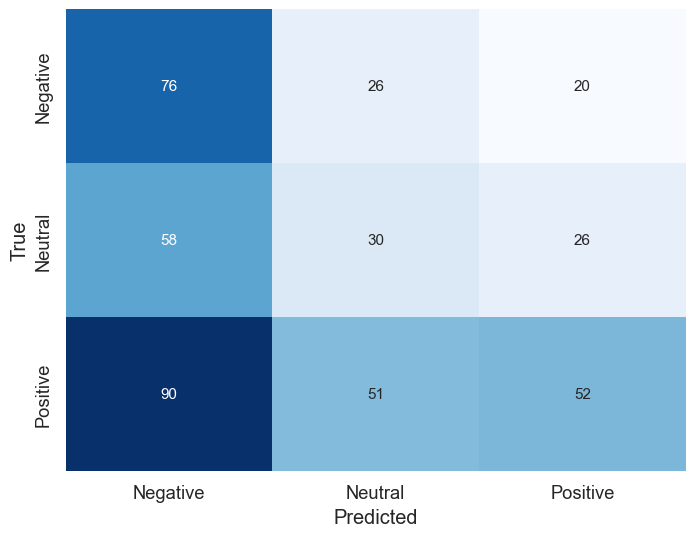

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Labels for the classes
labels = ['Negative', 'Neutral', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, 
            cbar_kws={'label': 'Number of Predictions'}, cbar = False, annot_kws={"size": 11})

plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_word2vec.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()


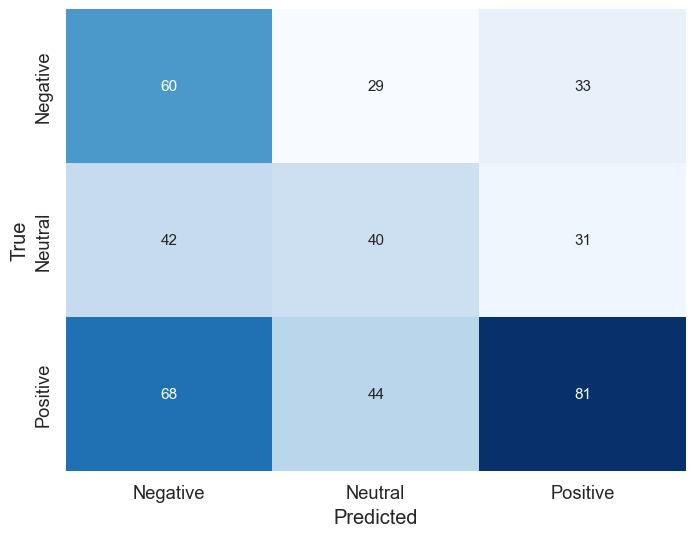

In [36]:
# Compare confusion matrix from RoBBERT model
conf_matrix = np.array([[60, 29, 33],
                        [42, 40, 31],
                        [68, 44, 81]])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust to fit labels
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, 
            cbar_kws={'label': 'Number of Predictions'}, cbar = False, annot_kws={"size": 11})

plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()